In [1]:
import os
import numpy as np
import csv
import random
import time
import pickle
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
os.chdir("C:\\Users\\Samir\\Desktop\\ENSAE\\GMML")

In [3]:
wordnet_mammal_file = 'wordnet_mammal_hypernyms.txt'

In [4]:
def load_wordnetload_wor (wordnet_path):
    network = {}
    with open(wordnet_path, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            if not row[0]==row[1]:
                if row[0] in network:
                    network[row[0]].append(row[1])
                else:
                    network.update({row[0]:[row[1]]})
    return network

In [5]:
network = load_wordnetload_wor(wordnet_mammal_file)
network

{'kangaroo.n.01': ['marsupial.n.01', 'mammal.n.01', 'metatherian.n.01'],
 'domestic_goat.n.01': ['even-toed_ungulate.n.01',
  'ruminant.n.01',
  'goat.n.01',
  'placental.n.01',
  'bovid.n.01',
  'ungulate.n.01',
  'mammal.n.01'],
 'rock_squirrel.n.01': ['ground_squirrel.n.02',
  'squirrel.n.01',
  'rodent.n.01',
  'mammal.n.01',
  'placental.n.01'],
 'vizsla.n.01': ['dog.n.01',
  'placental.n.01',
  'sporting_dog.n.01',
  'mammal.n.01',
  'carnivore.n.01',
  'canine.n.02',
  'pointer.n.04',
  'hunting_dog.n.01'],
 'dandie_dinmont.n.01': ['mammal.n.01',
  'terrier.n.01',
  'dog.n.01',
  'hunting_dog.n.01',
  'canine.n.02',
  'placental.n.01',
  'carnivore.n.01'],
 'broodmare.n.01': ['horse.n.01',
  'ungulate.n.01',
  'odd-toed_ungulate.n.01',
  'placental.n.01',
  'mare.n.01',
  'mammal.n.01',
  'equine.n.01'],
 'lesser_kudu.n.01': ['placental.n.01',
  'kudu.n.01',
  'even-toed_ungulate.n.01',
  'mammal.n.01',
  'antelope.n.01',
  'bovid.n.01',
  'ruminant.n.01',
  'ungulate.n.01'],
 '

In [6]:
def dist(u, v): 
    """Distance de Poincaré (équation 1 de l'article)"""
    return 1 + 2*np.dot(u - v, u - v)/ \
             ((1-np.dot(u, u))*(1-np.dot(v, v)) + EPSILON)

In [7]:
def partial_der(theta, x, gamma): 
    """Dérivée partielle par rapport à theta (equation 4 de l'article)"""
    alpha = (1.0-np.dot(theta, theta))
    norm_x = np.dot(x, x)
    beta = (1-norm_x)
    gamma = gamma
    return 4.0/(beta * np.sqrt(gamma*gamma - 1) + EPSILON)*((norm_x- 2*np.dot(theta, x)+1)/(pow(alpha,2)+EPSILON)*theta - x/(alpha + EPSILON))

In [8]:
def update(emb, error_, lr):
    """Equation d'update (equation 5)"""
    try:
        update =  lr*pow((1 - np.dot(emb,emb)), 2)*error_/4
        emb = emb - update
        if (np.dot(emb, emb) >= 1):
            emb = emb/sqrt(np.dot(emb, emb)) - EPSILON
        return emb
    except Exception as e:
        print (e)

In [9]:
#connaître les n noeuds les plus proches d'un autre noeud
def distance_min(node, n):
    #distance de chaque noeud au noeud node
    distance_to_node = np.zeros(len(vocab))
    #index des mots ayant la plus petite distance aux mots node
    index_minimum = np.zeros(n)
    for i in range(len(vocab)):
        distance_to_node[i] = dist(emb[node],emb[vocab[i]])
    index_minimum = np.argpartition(distance_to_node, n)
    for i in range(n):
        print(vocab[index_minimum[i]])

In [10]:
def get_vocabulary(network):
    vocab = list(emb.keys())
    vocab_weights = np.zeros(len(vocab))
    for key in network:
        for u in network[key]:
            vocab_weights[vocab.index(u)]+=1
    vocab_weights = vocab_weights / np.sum(vocab_weights)
    return vocab, vocab_weights

In [11]:
def initialize_embedding(network, embedding_size):
    """Comme dans l'article, on initialise la position des noeuds entre 0.001 et -0.001"""
    emb = {}
    gap = 1e-3
    for a in network:
        for b in network[a]:
            emb[b] = np.random.uniform(low=-gap, high=gap, size=(embedding_size,))
        emb[a] = np.random.uniform(low=-gap, high=gap, size=(embedding_size,))
    return emb

In [12]:
def get_negative_candidates(network, vocab, vocab_weights, u, num_negs):
    """Retourne une liste de mots qui ne sont pas liés à celui donné en entrée"""
    negs = []
    i = 0
    while (len(negs) < num_negs):
        neg = np.random.choice(vocab, p=vocab_weights)
        #neg = vocab[np.searchsorted(vocab_weights.cumsum(), random.random())]
        if not (neg in network[u] or u in network[neg] or neg == u): # neg ne doit pas etre lié à u et vice versa
            #or neg in negs
            negs.append(neg)
    return negs

In [13]:
def euclidian_dist(u,v):
    """Distance euclidienne"""
    return np.dot(u-v,u-v)

In [14]:
def poincare_dist(gamma): 
    """Distance de Poincaré (équation 1 de l'article)"""
    return np.arccosh(gamma)

In [15]:
def compute_gamma(vec1, vec2):
    euclidean_dists = np.linalg.norm(vec1 - vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    alpha = 1-norm1**2
    beta = 1-norm2**2
    gamma = 1 + 2*euclidean_dists/(alpha*beta)
    return gamma

In [16]:
def deriv_poincare_theta(theta, x, gamma): 
    """Dérivée partielle par rapport à theta de la distance de Poincare (equation 4 de l'article)"""
    alpha = (1.0-np.dot(theta, theta))
    norm_x = np.dot(x, x)
    beta = (1-norm_x)
    gamma = gamma
    return 4.0/(beta * np.sqrt(gamma*gamma - 1))*((norm_x- 2*np.dot(theta, x)+1)/(pow(alpha,2))*theta - x/(alpha))

In [17]:
#Initialisation des variables

embedding_size = 5 #dimension des vecteurs d'entrainement
emb = initialize_embedding(network, embedding_size)# embedding of nodes of network

#epochs
num_epochs = 2000

#burn-in, nombre d'épochs
nb_burn_in = 10

#nombre de nodes negatives pour l'entrainement
num_negs = 20

#learning rate
lr = 1e-2

#learning rate pour le burn-in
learning_rate_burn_in = 0.001

EPSILON = 0.00001 # evite l'overflow

vocab, vocab_weights = get_vocabulary(network)

In [18]:
# Randomly uniform distribution
for a in network:
    for b in network[a]:
        emb[b] = np.random.uniform(low=-0.001, high=0.001, size=(embedding_size,))
    emb[a] = np.random.uniform(low=-0.001, high=0.001, size=(embedding_size,))

vocab = list(emb.keys())

In [19]:
# #on supprime l'origine de la liste du vocabulaire, car il est lié à tous les mots
# index_origin = vocab.index("mammal.n.01")

# del vocab[index_origin]
# vocab_weights = np.delete(vocab_weights, index_origin)

# vocab_weights = vocab_weights/sum(vocab_weights)

In [20]:
#random.shuffle(vocab)

# the leave nodes are not connected to anything
for a in emb:
    if not a in network:
        network[a] = []

last_time = time.time()
loss_stock = np.zeros(num_epochs+nb_burn_in)
for epoch in range(num_epochs+nb_burn_in):
    loss_total = 0
    if epoch < nb_burn_in:
        burn_in = True
    else:
        burn_in = False
    for u in vocab:
        if not network[u]: # une node
            continue
        v = random.choice(network[u]) # u et v sont liés
        euclidian_dist_u_v = euclidian_dist(emb[u], emb[v])
        gamma_u_v = compute_gamma(emb[u], emb[v])
        dist_p_u_v = poincare_dist(gamma_u_v) # distance between the related nodes
        
        negs = [] # pairs of not related nodes, the first node in the pair is `pos1`
        gamma_u_negs = [] # distances entre nodes qui ne sont pas liées
        dist_negs = [] # distances entre nodes qui ne sont pas liées
        negs = get_negative_candidates(network, vocab, vocab_weights, u, num_negs) 
        for neg in negs:
            gamma_u_neg = compute_gamma(emb[u], emb[neg])
            gamma_u_negs.append(gamma_u_neg)
            dist_neg = poincare_dist(gamma_u_neg)
            dist_negs.append(dist_neg)
                
        loss_den = 0.0
        
        # eqn6
        for dist_neg in dist_negs:
            loss_den += np.exp(-1*dist_neg)
        loss = -1*dist_p_u_v - np.log(loss_den)
        #loss_euclidian = -1*euclidian_dist_u_v - np.log(loss_den)
        loss_total = loss_total + loss
        
        # derivative of loss wrt positive relation [d(u, v)]
        der_p = -1
        der_negs = []
        # derivative of loss wrt negative relation [d(u, v')]
        for dist_neg in dist_negs:
            der_negs.append(np.exp(-1*dist_neg)/(loss_den))
        # derivative of loss wrt pos1
        der_p_u = der_p * deriv_poincare_theta(emb[u], emb[v], gamma_u_v)
        # derivative of loss wrt pos2
        der_p_v = der_p * deriv_poincare_theta(emb[v], emb[u], gamma_u_v)
        
        der_negs_final = []        
        for (der_neg, neg, gamma_u_neg) in list(zip(der_negs, negs, gamma_u_negs)):
            # derivative of loss wrt second element of the pair in neg
            der_neg1 = der_neg * deriv_poincare_theta(emb[neg], emb[u], gamma_u_neg)
            # derivative of loss wrt first element of the pair in neg
            der_neg0 = der_neg * deriv_poincare_theta(emb[u], emb[neg], gamma_u_neg)
            der_negs_final.append([der_neg0, der_neg1])
        
        # update embeddings now
        if burn_in:
            emb[u] = update(emb[u], -1*der_p_u, learning_rate_burn_in)
            emb[v] = update(emb[v], -1*der_p_v, learning_rate_burn_in)  
        else:
            emb[u] = update(emb[u], -1*der_p_u, lr)
            emb[v] = update(emb[v], -1*der_p_v, lr)
        for (neg, der_neg) in list(zip(negs, der_negs_final)):
            if burn_in:
                emb[u] = update(emb[u], -1*der_neg[0], learning_rate_burn_in)
                emb[neg] = update(emb[neg], -1*der_neg[1], learning_rate_burn_in)
            else:
                emb[u] = update(emb[u], -1*der_neg[0], lr)
                emb[neg] = update(emb[neg], -1*der_neg[1], lr) 
    print(loss_total)
    loss_stock[epoch] = loss_total
                
    print('Epoch #%d, temps d\'exécution: %.2f seconds' % (epoch + 1, time.time() - last_time))
    last_time = time.time()
#pickle.dump(emb, open('data/train.pickle', 'wb'))

-3532.178767367511
Epoch #1, temps d'exécution: 8.70 seconds
-3528.5496025755315
Epoch #2, temps d'exécution: 7.59 seconds
-3526.1985436385407
Epoch #3, temps d'exécution: 7.93 seconds
-3525.1999078308218
Epoch #4, temps d'exécution: 7.48 seconds
-3524.3506995428243
Epoch #5, temps d'exécution: 7.75 seconds
-3522.2802266716717
Epoch #6, temps d'exécution: 7.62 seconds
-3521.9710197242857
Epoch #7, temps d'exécution: 7.70 seconds
-3520.5863929640113
Epoch #8, temps d'exécution: 7.53 seconds
-3517.7557862354906
Epoch #9, temps d'exécution: 7.45 seconds
-3514.796299658758
Epoch #10, temps d'exécution: 7.62 seconds
-3506.976283006647
Epoch #11, temps d'exécution: 7.52 seconds
-3489.456506492654
Epoch #12, temps d'exécution: 7.62 seconds
-3483.486567856044
Epoch #13, temps d'exécution: 7.66 seconds
-3459.694434203884
Epoch #14, temps d'exécution: 7.69 seconds
-3442.298316723471
Epoch #15, temps d'exécution: 7.48 seconds
-3431.5878564070995
Epoch #16, temps d'exécution: 7.55 seconds
-3423.67

-2594.9257168334802
Epoch #132, temps d'exécution: 8.49 seconds
-2610.5762126417
Epoch #133, temps d'exécution: 8.40 seconds
-2645.8712548687304
Epoch #134, temps d'exécution: 8.32 seconds
-2549.0754308886803
Epoch #135, temps d'exécution: 8.75 seconds
-2565.5113392264684
Epoch #136, temps d'exécution: 8.48 seconds
-2583.6100604410044
Epoch #137, temps d'exécution: 8.65 seconds
-2578.433019052467
Epoch #138, temps d'exécution: 8.62 seconds
-2582.9523576844576
Epoch #139, temps d'exécution: 8.50 seconds
-2516.148931336558
Epoch #140, temps d'exécution: 8.43 seconds
-2501.084663438493
Epoch #141, temps d'exécution: 8.32 seconds
-2530.273136758675
Epoch #142, temps d'exécution: 8.67 seconds
-2521.3519299372056
Epoch #143, temps d'exécution: 9.35 seconds
-2545.261759266775
Epoch #144, temps d'exécution: 9.37 seconds
-2530.057643747888
Epoch #145, temps d'exécution: 8.08 seconds
-2442.02487370562
Epoch #146, temps d'exécution: 9.60 seconds
-2456.4585995059374
Epoch #147, temps d'exécution: 

-1090.2419877424047
Epoch #261, temps d'exécution: 7.45 seconds
-984.7486207091721
Epoch #262, temps d'exécution: 7.59 seconds
-889.7987601140263
Epoch #263, temps d'exécution: 7.68 seconds
-747.7297030530335
Epoch #264, temps d'exécution: 7.54 seconds
-799.498851255855
Epoch #265, temps d'exécution: 7.59 seconds
-803.0694168440584
Epoch #266, temps d'exécution: 7.54 seconds
-922.1989490824398
Epoch #267, temps d'exécution: 7.64 seconds
-774.2681086696241
Epoch #268, temps d'exécution: 7.53 seconds
-847.394530972735
Epoch #269, temps d'exécution: 7.69 seconds
-900.9200750698379
Epoch #270, temps d'exécution: 7.89 seconds
-922.3283791649845
Epoch #271, temps d'exécution: 7.79 seconds
-796.0200813620862
Epoch #272, temps d'exécution: 7.69 seconds
-746.6055146826942
Epoch #273, temps d'exécution: 7.50 seconds
-674.7632855322768
Epoch #274, temps d'exécution: 7.80 seconds
-829.4733539030063
Epoch #275, temps d'exécution: 8.04 seconds
-809.4793559485007
Epoch #276, temps d'exécution: 7.63 s

1208.3911464022117
Epoch #392, temps d'exécution: 8.08 seconds
1639.6057910791828
Epoch #393, temps d'exécution: 9.27 seconds
1484.5696117965206
Epoch #394, temps d'exécution: 7.68 seconds
1415.8637191048751
Epoch #395, temps d'exécution: 7.57 seconds
1465.5848897798928
Epoch #396, temps d'exécution: 7.52 seconds
1240.1165499332578
Epoch #397, temps d'exécution: 7.46 seconds
2045.1787985610824
Epoch #398, temps d'exécution: 7.49 seconds
1481.012176746717
Epoch #399, temps d'exécution: 7.50 seconds
1751.7048242911903
Epoch #400, temps d'exécution: 7.52 seconds
1603.9036898584948
Epoch #401, temps d'exécution: 7.47 seconds
1671.9364075254757
Epoch #402, temps d'exécution: 7.58 seconds
1379.2576910250962
Epoch #403, temps d'exécution: 7.46 seconds
1766.8946807478007
Epoch #404, temps d'exécution: 7.71 seconds
1466.6933816446965
Epoch #405, temps d'exécution: 12.82 seconds
1998.9814513992762
Epoch #406, temps d'exécution: 11.63 seconds
1797.9997127639085
Epoch #407, temps d'exécution: 11.6

3958.714150991406
Epoch #523, temps d'exécution: 9.20 seconds
3864.788249759445
Epoch #524, temps d'exécution: 9.33 seconds
3806.9848334416492
Epoch #525, temps d'exécution: 10.42 seconds
4114.460359648365
Epoch #526, temps d'exécution: 11.56 seconds
4001.377310527611
Epoch #527, temps d'exécution: 10.60 seconds
4153.165596896375
Epoch #528, temps d'exécution: 9.98 seconds
3913.75012846733
Epoch #529, temps d'exécution: 13.34 seconds
4685.620800975169
Epoch #530, temps d'exécution: 10.39 seconds
4152.2001524578955
Epoch #531, temps d'exécution: 10.85 seconds
4367.0915143502
Epoch #532, temps d'exécution: 10.73 seconds
4323.93439584448
Epoch #533, temps d'exécution: 9.41 seconds
4542.146774700234
Epoch #534, temps d'exécution: 9.32 seconds
4343.69766536188
Epoch #535, temps d'exécution: 9.16 seconds
4357.5443720877065
Epoch #536, temps d'exécution: 11.74 seconds
4252.185651853396
Epoch #537, temps d'exécution: 8.23 seconds
3971.423841240181
Epoch #538, temps d'exécution: 10.00 seconds
4

6892.6417457819125
Epoch #655, temps d'exécution: 7.97 seconds
6148.409583931488
Epoch #656, temps d'exécution: 7.58 seconds
6558.250998261121
Epoch #657, temps d'exécution: 7.67 seconds
7243.702520234368
Epoch #658, temps d'exécution: 7.63 seconds
6337.310605391106
Epoch #659, temps d'exécution: 7.47 seconds
6351.364579536488
Epoch #660, temps d'exécution: 7.62 seconds
5879.0525721097165
Epoch #661, temps d'exécution: 7.59 seconds
6388.105586431541
Epoch #662, temps d'exécution: 7.60 seconds
6385.216492585834
Epoch #663, temps d'exécution: 7.55 seconds
6877.065830188653
Epoch #664, temps d'exécution: 7.58 seconds
6684.6471443549335
Epoch #665, temps d'exécution: 7.68 seconds
7025.685749369882
Epoch #666, temps d'exécution: 7.58 seconds
7093.905794820341
Epoch #667, temps d'exécution: 7.63 seconds
6993.467512238823
Epoch #668, temps d'exécution: 7.63 seconds
6895.757378958644
Epoch #669, temps d'exécution: 7.57 seconds
7023.147681749074
Epoch #670, temps d'exécution: 7.60 seconds
7028.

8643.249771395509
Epoch #788, temps d'exécution: 7.52 seconds
9403.559875122097
Epoch #789, temps d'exécution: 7.42 seconds
9974.769005010323
Epoch #790, temps d'exécution: 7.58 seconds
9357.317598654294
Epoch #791, temps d'exécution: 7.69 seconds
8754.086526368766
Epoch #792, temps d'exécution: 7.54 seconds
8900.468558488205
Epoch #793, temps d'exécution: 7.66 seconds
10127.435974277096
Epoch #794, temps d'exécution: 7.57 seconds
9059.827799621733
Epoch #795, temps d'exécution: 7.62 seconds
9711.420587341112
Epoch #796, temps d'exécution: 7.57 seconds
9951.57593893915
Epoch #797, temps d'exécution: 7.49 seconds
9702.444520520394
Epoch #798, temps d'exécution: 7.84 seconds
9521.950957669804
Epoch #799, temps d'exécution: 7.51 seconds
9656.197556378238
Epoch #800, temps d'exécution: 7.62 seconds
9038.288325548026
Epoch #801, temps d'exécution: 7.53 seconds
9665.160370604232
Epoch #802, temps d'exécution: 7.54 seconds
9728.606636030887
Epoch #803, temps d'exécution: 7.55 seconds
8976.846

10511.646418302782
Epoch #920, temps d'exécution: 7.46 seconds
9939.193490095424
Epoch #921, temps d'exécution: 7.53 seconds
9652.459486690224
Epoch #922, temps d'exécution: 7.49 seconds
9741.898906546847
Epoch #923, temps d'exécution: 7.40 seconds
10658.117010639227
Epoch #924, temps d'exécution: 7.43 seconds
9600.378311775978
Epoch #925, temps d'exécution: 7.48 seconds
10169.779985979072
Epoch #926, temps d'exécution: 7.75 seconds
9751.945639509244
Epoch #927, temps d'exécution: 7.49 seconds
10002.329172723463
Epoch #928, temps d'exécution: 7.43 seconds
11005.236079735992
Epoch #929, temps d'exécution: 7.57 seconds
10652.706313204115
Epoch #930, temps d'exécution: 7.57 seconds
10499.271721681105
Epoch #931, temps d'exécution: 7.45 seconds
9903.957895582666
Epoch #932, temps d'exécution: 7.53 seconds
9654.04122927144
Epoch #933, temps d'exécution: 7.44 seconds
9397.4469345537
Epoch #934, temps d'exécution: 7.37 seconds
9856.684769083542
Epoch #935, temps d'exécution: 7.46 seconds
9653

## Résultats

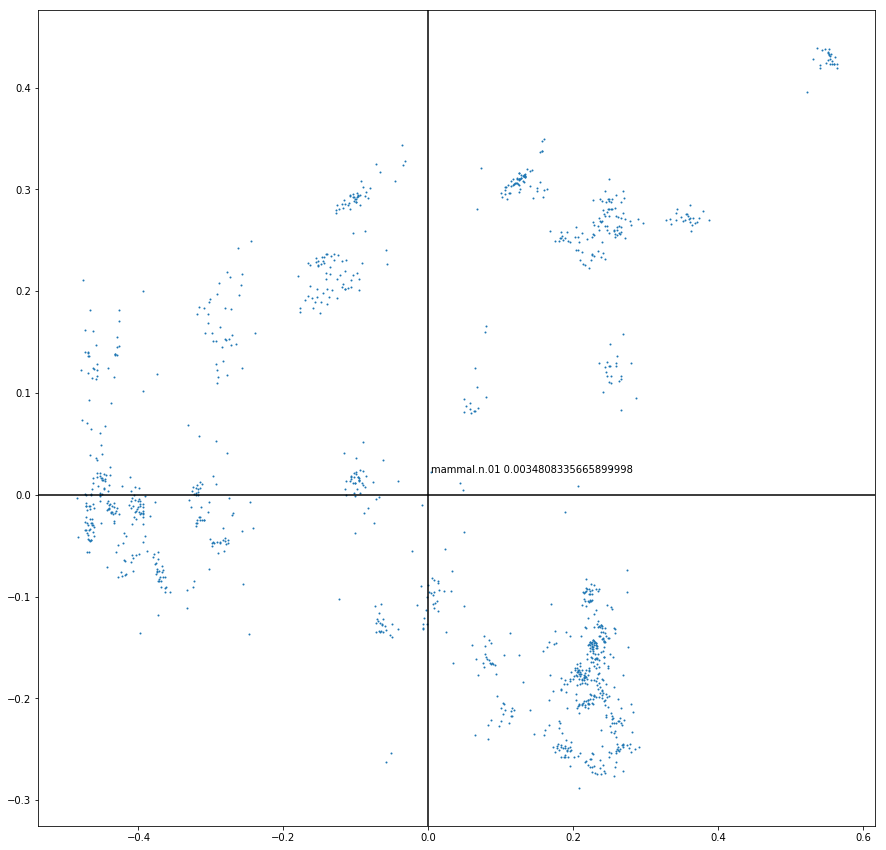

In [21]:
fig=plt.figure(figsize=(15,15))
names = []
positions_x = []
positions_y = []
for key in emb:
    names.append(key)
    positions_x.append(emb[key][0])
    positions_y.append(emb[key][1])

plt.scatter(positions_x,positions_y, s=1)
k=1
plt.text(positions_x[k], positions_y[k], names[k] + " " + str(positions_x[k]), fontsize=10)

# circle = plt.Circle((0, 0), 1, color='g',fill=False)

# plt.axis([-1,1,-1,1])
# ax=fig.add_subplot(1,1,1)
# ax.add_patch(circle)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.show()

In [22]:
def evaluate_mean_rank_and_map(vocab, network, embeddings, max_n=None):
    """Evalue le mean rank et le MAP pour la reconstruction."""
    ranks = []
    avg_precision_scores = []
    for i, item in list(enumerate(vocab, start=0)):
        if item not in network or item == "mammal.n.01":
            continue
        item_relations = []
        temp = list(embeddings.keys())
        for relation in network[item]:
            item_relations.append(temp.index(relation))
            
        item_distances = all_distances_to(item, embeddings)
#         print("item", item)
        positive_relation_ranks, avg_precision = \
            get_positive_relation_ranks_and_avg_prec(item_distances, item_relations)
        ranks += positive_relation_ranks
        avg_precision_scores.append(avg_precision)
        if max_n is not None and i > max_n:
            break
    return np.mean(ranks), np.mean(avg_precision_scores)

def all_distances_to(item, embeddings):
    """Retourne une liste des distances d'un mot avec tous les autres"""
    all_distances=np.zeros(len(list(embeddings.keys())))
    
    for i, elem in list(enumerate(embeddings)):
        gamma = compute_gamma(embeddings[item], embeddings[elem])
        distance = poincare_dist(gamma)
        all_distances[i]=distance
    return all_distances
    
def get_positive_relation_ranks_and_avg_prec(all_distances, positive_relations):
    """
    Given a numpy array of all distances from an item and indices of its positive relations,
    compute ranks and Average Precision of positive relations.
    """
#     print("positive_relations", positive_relations)
    positive_relation_distances = all_distances[positive_relations]
    negative_relation_distances = np.ma.array(all_distances, mask=False)
#     value_max = np.nanmax(negative_relation_distances)
#     print('value_max', value_max)
    inds = np.where(np.isnan(negative_relation_distances))
#     if inds[0].shape[0]>0:
#         print('inds', inds)
#     negative_relation_distances[inds] = value_max

#     negative_relation_distances.mask[positive_relations] = True
    # Compute how many negative relation distances are less than each positive relation distance, plus 1 for rank
    ranks = (negative_relation_distances < positive_relation_distances[:, np.newaxis]).sum(axis=1) + 1
#     print("ranks :",ranks)
    map_ranks = np.sort(ranks) + np.arange(len(ranks))
    avg_precision = ((np.arange(1, len(map_ranks) + 1) / np.sort(map_ranks)).mean())
#     print("avg_precision", avg_precision)
    return list(ranks), avg_precision

In [23]:
mean_rank, map_ = evaluate_mean_rank_and_map(vocab, network, emb)

In [24]:
print('WordNet reconstruction')
print('Paramètres :')
print('Période de burn-in =', nb_burn_in)
print("Epochs =", num_epochs)
print("Learning rate =", lr)
print("Burn-in learning rate =", learning_rate_burn_in)
print("Dimension =", embedding_size)
print("un nombre de nodes négatives de", num_negs)
print("epsilon =", EPSILON)
print()
print("Résultats :")
print('Mean Rank =', mean_rank, "\nMAP =", map_)

WordNet reconstruction
Paramètres :
Période de burn-in = 10
Epochs = 1000
Learning rate = 0.01
Burn-in learning rate = 0.001
Dimension = 20
un nombre de nodes négatives de 20
epsilon = 1e-05

Résultats :
Mean Rank = 588.7639865484562 
MAP = 0.18647349048755069


## Prédiction

In [25]:
def get_root_and_leaf_nodes(data_file):
    """Return keys of root and leaf nodes from a file with transitive closure relations"""
    root_candidates = set()
    leaf_candidates = set()
    with open(data_file, 'rb') as f:
        for line in f:
            nodes = line.split()
            root_candidates.update(nodes)
            leaf_candidates.update(nodes)
    
    with open(data_file, 'rb') as f:
        for line in f:
            node_1, node_2 = line.split()
            if node_1 == node_2:
                continue
            leaf_candidates.discard(node_1)
            root_candidates.discard(node_2)
    
    return (leaf_candidates, root_candidates)

In [26]:
def train_test_split(data_file, test_ratio=0.1):
    train_filename = data_file + '.train'
    test_filename = data_file + '.test'
    if os.path.exists(train_filename) and os.path.exists(test_filename):
        return (train_filename, test_filename)
    root_nodes, leaf_nodes = get_root_and_leaf_nodes(data_file)
    test_line_candidates = []
    line_count = 0
    all_nodes = set()
    with open(data_file, 'rb') as f:
        for i, line in list(enumerate(f)):
            node_1, node_2 = line.split()
            all_nodes.update([node_1, node_2])
            if (
                    node_1 not in leaf_nodes
                    and node_2 not in leaf_nodes
                    and node_1 not in root_nodes
                    and node_2 not in root_nodes
                    and node_1 != node_2
                ):
                test_line_candidates.append(i)
            line_count += 1

    num_test_lines = int(test_ratio * line_count)
    test_line_indices = set(random.sample(test_line_candidates, num_test_lines))
    train_line_indices = set(l for l in range(line_count) if l not in test_line_indices)
    
    train_set_nodes = set()
    with open(data_file, 'rb') as f:
        train_file = open(train_filename, 'wb')
        test_file = open(test_filename, 'wb')
        for i, line in list(enumerate(f)):
            if i in train_line_indices:
                train_set_nodes.update(line.split())
                train_file.write(line)
            elif i in test_line_indices:
                test_file.write(line)
        train_file.close()
        test_file.close()
    assert len(train_set_nodes) == len(all_nodes), 'Not all nodes from dataset present in train set relations'
    return (train_filename, test_filename)

In [27]:
def evaluate_mean_rank_and_map_prediction(vocab, embeddings, items, relations, max_n=None):
    """Evaluate mean rank and MAP for link prediction."""
    ranks = []
    avg_precision_scores = []
    for i, item in list(enumerate(items, start=0)):
        if item not in relations['unknown'] or item == "mammal.n.01":
        #or item == "mammal.n.01":  # No positive relations to predict for this node
            continue
        unknown_relations = []
        for elem in list(relations['unknown'][item]):
            unknown_relations.append(vocab.index(elem))
        known_relations = []
        for elem in list(relations['known'][item]):
            known_relations.append(vocab.index(elem))
        
        item_distances = all_distances_to(item, embeddings)
        unknown_relation_ranks, avg_precision = \
            get_unknown_relation_ranks_and_avg_prec(item_distances, unknown_relations, known_relations)
        ranks += unknown_relation_ranks
        avg_precision_scores.append(avg_precision)
        if max_n is not None and i > max_n:
            break
    return np.mean(ranks), np.mean(avg_precision_scores)

In [28]:
def get_unknown_relation_ranks_and_avg_prec(all_distances, unknown_relations, known_relations):
    unknown_relation_distances = all_distances[unknown_relations]
    negative_relation_distances = np.ma.array(all_distances, mask=False)
    negative_relation_distances.mask[unknown_relations] = True
    negative_relation_distances.mask[known_relations] = True
    # Compute how many negative relation distances are less than each unknown relation distance, plus 1 for rank
    ranks = (negative_relation_distances < unknown_relation_distances[:, np.newaxis]).sum(axis=1) + 1
    map_ranks = np.sort(ranks) + np.arange(len(ranks))
    avg_precision = ((np.arange(1, len(map_ranks) + 1) / np.sort(map_ranks)).mean())
    return list(ranks), avg_precision

In [29]:
train_filename , test_filename = train_test_split('wordnet_mammal_hypernyms.txt', test_ratio=0.1)

In [30]:
from collections import defaultdict

In [31]:
relations = {'known': defaultdict(set), 'unknown': defaultdict(set)}
data_files = {'known': train_filename, 'unknown': test_filename}

In [32]:
items = set()
for relation_type, data_file in data_files.items():
    with open(data_file, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            relations[relation_type][row[0]].add(row[1])
            items.update([row[0], row[1]])

In [33]:
mean_rank, map_ = evaluate_mean_rank_and_map_prediction(vocab, emb, items, relations)

In [34]:
print('Link prediction')
print('Paramètres :')
print('Période de burn-in =', nb_burn_in)
print("Epochs =", num_epochs)
print("Learning rate =", lr)
print("Burn-in learning rate =", learning_rate_burn_in)
print("Dimension =", embedding_size)
print("un nombre de nodes négatives de", num_negs)
print("epsilon =", EPSILON)
print()
print("Résultats :")
print('Mean Rank =', mean_rank, "\nMAP =", map_)

Link prediction
Paramètres :
Période de burn-in = 10
Epochs = 1000
Learning rate = 0.01
Burn-in learning rate = 0.001
Dimension = 20
un nombre de nodes négatives de 20
epsilon = 1e-05

Résultats :
Mean Rank = 652.8367875647668 
MAP = 0.34458414163565143
